# Importing Libraries & Setting up device-agnostic code

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

# Get data
* Our dataset is a subset of the `torchvision.datasets.Food101` dataset.

In [2]:
import requests
import zipfile
from pathlib import Path


TARGET_URL = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

file_path = data_path / TARGET_URL.split("/")[-1]

if image_path.is_dir():
    print(f"{image_path} directory already exists, skipping download...")
    
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(file_path, "wb") as f:
        response = requests.get(TARGET_URL)
        print("Downloading pizza steak sushi data...")

        f.write(response.content)

    with zipfile.ZipFile(file_path, "r") as zip_ref:
        print("Unzipping pizza steak sushi data...")
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists, skipping download...


# Data Preparation & Exploration

In [3]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories, and {len(filenames)} images in '{dirpath}'.")

In [4]:
walk_through_dir(image_path)

There are 2 directories, and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories, and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories, and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories, and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories, and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories, and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories, and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories, and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories, and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [5]:
train_dir =  image_path / "train"
test_dir = image_path / "test"

* Let's write some code to:
    1. Get all the image paths
    2. Pick a random image path using Python's `random.choice()`
    3. Get the image class name using `pathlip.Path.parent.stem`
    4. Open the image with Python's `PIL`
    5. Show the image and print metadata

Random Image Path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image Class: sushi
Image Height: 408
Image Width: 512


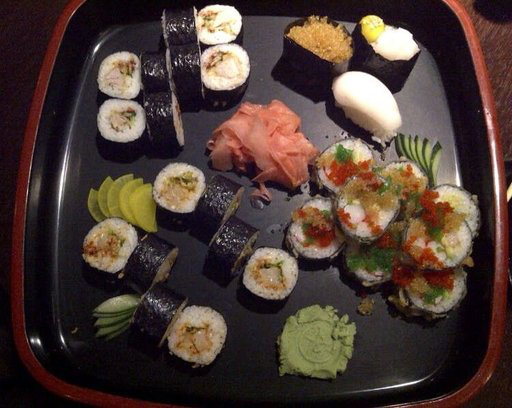

In [6]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random Image Path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

# Transforming data

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [8]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [9]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            
            # plot the original one before the transformation
            ax[0].imshow(f)
            ax[0].set_title(f"Original\n Size: {f.size}")
            ax[0].axis("off")
            # plot the transformed image after the transformation
            transformed_img = transform(f)
            transformed_img = torch.permute(transformed_img, (2, 1, 0))
            
            ax[1].imshow(transformed_img)
            ax[1].set_title(f"Transformed\n Shape: {transformed_img.size()}")
            ax[1].axis("off")

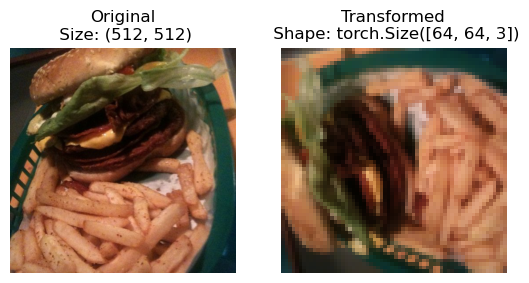

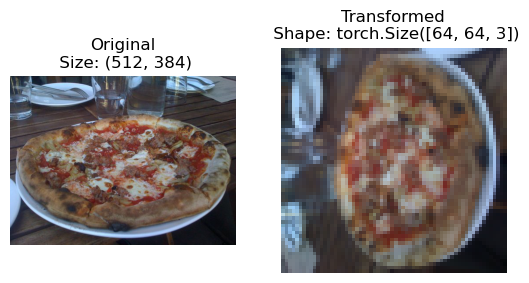

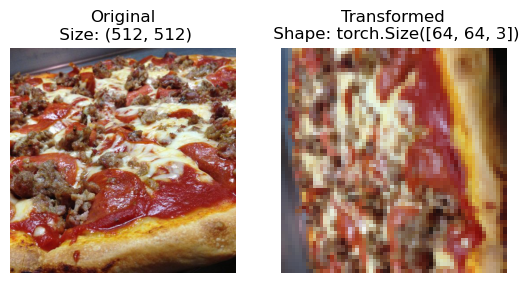

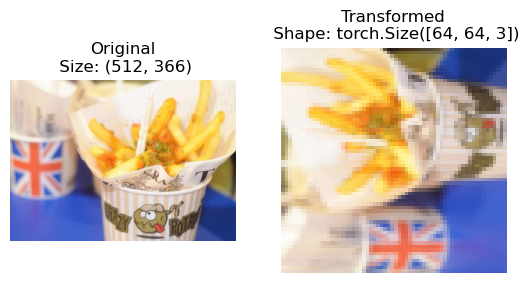

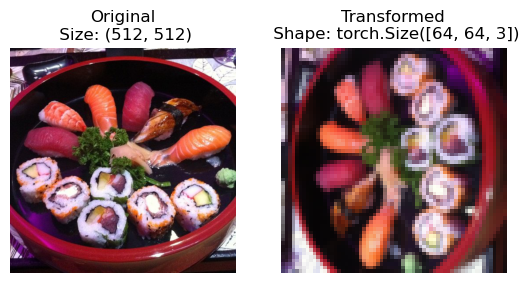

In [10]:
plot_transformed_images(image_path_list, data_transform, 5)

# Loading image data
## Option: 1
###  using `torchvision.datasets.ImageFolder`

In [11]:
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,
    target_transform=None,
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform,
    target_transform=None,
)

In [12]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [13]:
# Get class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Get class names as dict `class to index`
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

### Turn loaded images into `Dataloader`

In [15]:
import multiprocessing

num_workers = multiprocessing.cpu_count()
num_workers

12

In [16]:
BATCH_SIZE = 4
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
)

In [17]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x27a84e14c10>,
 <torch.utils.data.dataloader.DataLoader at 0x27a841e5050>)

## Option: 2
### Using Custom datasets `torch.utils.data.Dataset`

1. Creating a helper function to get class names


In [18]:
import os
import pathlib
from PIL import Image
from typing import Tuple, Dict, List

import torch
from torch.utils.data import Dataset
from torchvision import transforms


In [19]:
class_names_found = sorted([entry.name for entry in list(os.scandir(train_dir))])
class_names_found

['pizza', 'steak', 'sushi']

In [20]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in list(os.scandir(train_dir)))
    
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes..")
        
    class_to_idx = {name: i for i, name in enumerate(classes)}
    
    return classes, class_to_idx

In [21]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

2. Creating a custom `Dataset` to replicate `ImageFolder`
    * To create our own custom dataset, we want to:
        1. Subclass `torch.utils.data.Dataset`
        2. Init our subclass with a target directory, as well as a transform.
        3. Create several attributes:
            * paths pf our images
            * the transform we would like to use
            * a list of the target classes
            * a dict of the target classes mapped to integer labels
        4. Create a function to `load_images()`
        5. overwrite `__getitem()__`
        6. overwrite `__len()__`

In [22]:
class ImageFolderCustom(Dataset):
    def __init__(self, datadir: str, transform=None):
        self.paths = list(pathlib.Path(datadir).glob("*/*.jpg"))
        if transform:
            self.transform = transform
            
        self.classes, self.class_to_idx = find_classes(datadir)
        
    def load_image(self, index: int) -> Image.Image: 
        return Image.open(self.paths[index])
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_to_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_to_idx
        else:
            return img, class_to_idx
        

In [23]:
# Test ImageFolderCustom
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=(0.5)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [24]:
train_data_custom = ImageFolderCustom(train_dir, train_transforms)
test_data_custom = ImageFolderCustom(test_dir, test_transforms)

In [25]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x27a841f7d50>,
 <__main__.ImageFolderCustom at 0x27a84e42150>)

In [26]:
len(train_data), len(train_data_custom)

(225, 225)

In [27]:
len(test_data), len(test_data_custom)

(75, 75)

In [28]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

3. Create a function to display random images


In [29]:
def diaplay_random_images(
    dataset: torch.utils.data.Dataset,
    classes: List[str] = None,
    n: int = 10,
    display_shape: bool = True,
    seed: int = None
):
    
    if n > 10:
        n = 10
        display_shape = False
        print("n should not be larger than 10.")
        
    if seed:
        random.seed(seed)
        
    plt.figure(figsize=(18, 6))
        
    random_image_idx = random.sample(range(len(dataset)), k=n)
    for i, idx in enumerate(random_image_idx):
        img, label = dataset[idx]
        
        img_adjust = img.permute(1, 2, 0)
        
        plt.subplot(1, n, i+1)
        plt.imshow(img_adjust)
        plt.axis("off")
        
        if classes:
            title = f"Classes: {classes[label]}"
            if display_shape:
                title += f"\nShape: {img_adjust.shape}"
                
        plt.title(title)


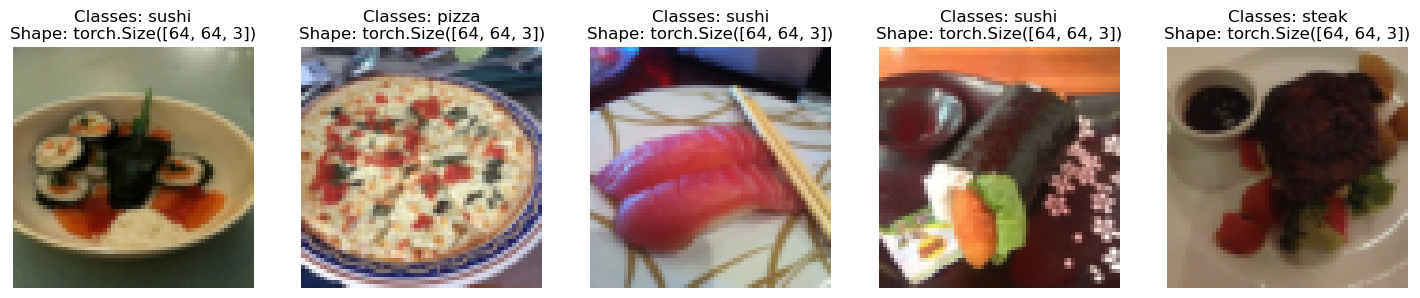

In [30]:
# Display random images from ImageFolder.
diaplay_random_images(
    train_data,
    class_names,
    n=5,
)

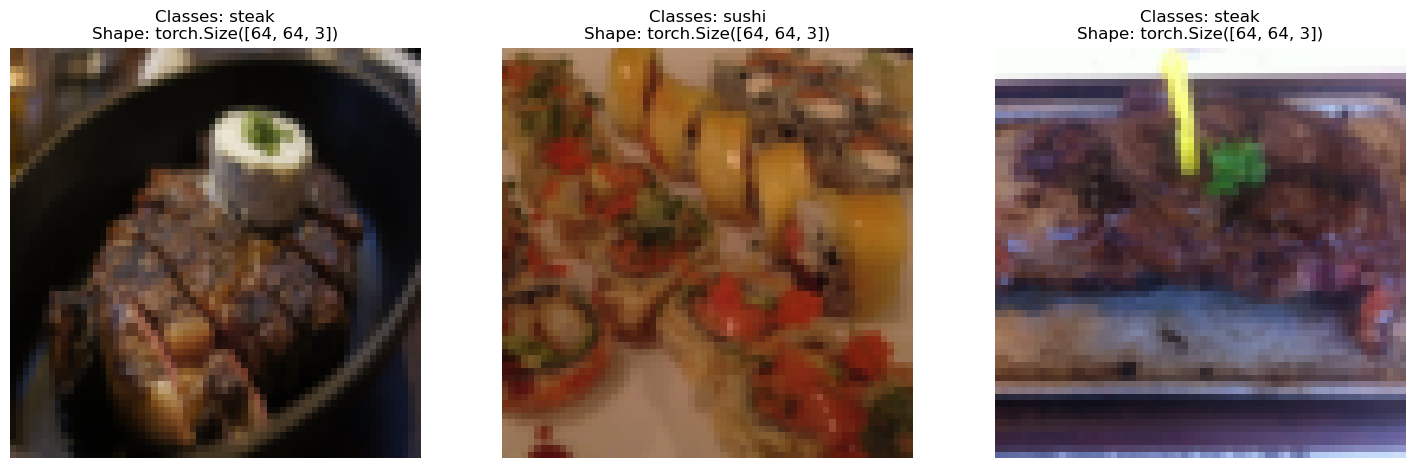

In [31]:
# Display random images from ImageFolderCustom.
diaplay_random_images(
    train_data_custom,
    class_names,
    n=3,
    seed=9
)

## Turn custom loaded images into `DataLoader`

In [32]:
import multiprocessing

NUM_WORKERS = multiprocessing.cpu_count()
BATCH_SIZE = 4

In [33]:
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(
    dataset=train_data_custom,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader_custom = DataLoader(
    dataset=test_data_custom,
    batch_size=BATCH_SIZE,
)

In [34]:
train_dataloader_custom

In [35]:
img_custom, label_custom = next(iter(train_dataloader_custom))

In [36]:
img_custom.shape # (batch_size, color_channel, Height, width)

torch.Size([4, 3, 64, 64])

# Data Augmentation
* Let's play with `TrivialAugmentWide`

In [37]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [38]:
image_path_list[:4]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg')]

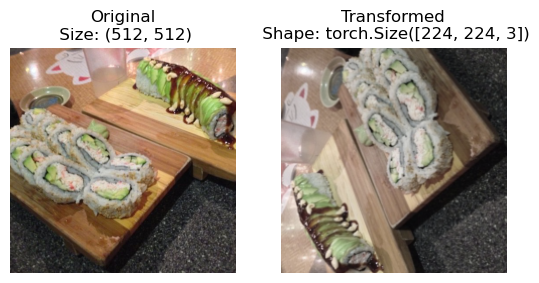

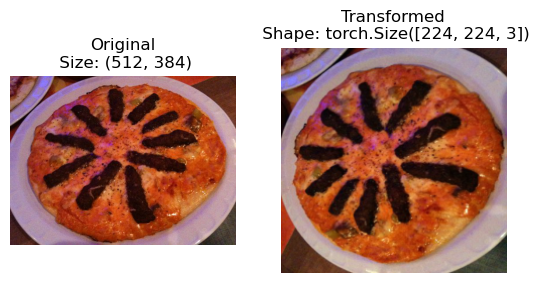

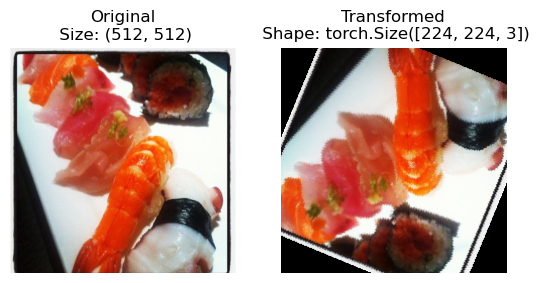

In [39]:
plot_transformed_images(
    image_path_list,
    train_transform,
    n=3,
    seed=70
)

# Model 0: TinyVGG without data augmentation 

## Creating transforms and loading data for Model 0

In [124]:
from torchvision import transforms

simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [125]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

train_data = ImageFolder(
    root=train_dir,
    transform=simple_transform,
)

test_data = ImageFolder(
    root=test_dir,
    transform=simple_transform,
)

In [126]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [127]:
# Turn the dataset into DataLoader
BATCH_SIZE = 32

train_loader = DataLoader(
    dataset=train_data,
    shuffle=True,
    batch_size=BATCH_SIZE,
)

test_loader = DataLoader(
    dataset=test_data,
    shuffle=False,
    batch_size=BATCH_SIZE,
)

## Create TinyVGG model class

In [128]:

class TinyVGG(torch.nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        
        self.conv_block_1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_block_2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=13*13*hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
#         print(f"Conv block 1: {x.shape}")
        x = self.conv_block_2(x)
#         print(f"Conv block 2: {x.shape}")
        x = self.classifier(x)
#         print(f"Classifier output: {x.shape}")
        return x
#         return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [129]:
torch.manual_seed(42)

model_0 = TinyVGG(3, 10, len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [130]:
# Try a forward pass on a single image

image_batch, label_batch = next(iter(train_loader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [131]:
output = model_0(image_batch)
output

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6315e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0999e-02,  1.2869e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7293e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1837e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4455e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7724e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5021e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4219e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8245e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

In [132]:
pred_classes = torch.argmax(torch.softmax(output, dim=-1), dim=-1)
pred_classes

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [133]:
((pred_classes == label_batch).sum() / len(label_batch)).item()

0.46875

In [134]:
len(output)

32

## Use `torchinfo` to get an idea of the shapes.

In [135]:
!pip install torchinfo

In [136]:
from torchinfo import summary

In [137]:
summary(model_0, input_size=image_batch.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

## Train and Test loops functions

In [138]:
from tqdm.auto import tqdm
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

epochs = 32

* Train step function

In [139]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    device=device
):
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # 1. Forward Pass
        output = model(X) # outputs will be a logits
        
        # 2. Calculate the loss
        loss = loss_fn(output, y)
        train_loss += loss.item() # loss per batch
        
        #3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. backward pass
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
        # Calculate the acc
        y_pred_classes = torch.argmax(torch.softmax(output, dim=-1), dim=-1)
        train_acc += ((y_pred_classes == y).sum() / len(y)).item() # acc per batch
        
#     adjust metrics to get all loss/accuracy values per all of the data
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_acc, train_loss

* Test step function

In [140]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device=device
):
    
    model.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            
            X, y = X.to(device), y.to(device)
            outputs = model(X)

            loss = loss_fn(outputs, y)
            
            test_loss += loss.item()
            
            y_pred_classes = torch.argmax(torch.softmax(outputs, dim=-1), dim=-1)
            test_acc += (y_pred_classes == y).sum().item() / len(y)
            
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    
    return test_acc, test_loss

In [141]:
# Define loss function & optimizer
loss_fn = CrossEntropyLoss()
optimizer = SGD(model_0.parameters(), lr=0.01)

* Put all together `trian_step` and `test_step` functions

In [142]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int = 5,
    device: torch.device = device
):
#     Result dictionary
    result = {
        "train_acc": [],
        "train_loss": [],
        "test_acc": [],
        "test_loss": [],
    }
#     loop throught train, and test step functions
    for epoch in tqdm(range(epochs)):
        
        train_acc, train_loss = train_step(model, train_dataloader, optimizer, loss_fn, device)
        
        test_acc, test_loss = test_step(model, test_dataloader, loss_fn, device)
        
#         print out the result
        print(
            f"Epoch: {epoch} | Train acc: {train_acc:.4f}, Train Loss: {train_loss:.4f} | Test acc: {test_acc:.4f}, Test Loss: {test_loss:.4f}"
        )
    
        result["train_acc"].append(train_acc)
        result["train_loss"].append(train_loss)
        result["test_acc"].append(test_acc)
        result["test_loss"].append(test_loss)
    return result


## Train & Evaluate model 0

In [143]:
torch.manual_seed(42)

NUM_EPOCHS = 50

model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)

optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [144]:
# Start time
from timeit import default_timer as timer

start = timer()

# Train the model

model_0_result = train(
    model=model_0,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device
)

# End the timer
end = timer()

print(f"Total training time: {end - start:.4f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train acc: 0.3047, Train Loss: 1.1063 | Test acc: 0.3116, Test Loss: 1.0983
Epoch: 1 | Train acc: 0.3320, Train Loss: 1.0995 | Test acc: 0.5417, Test Loss: 1.0698
Epoch: 2 | Train acc: 0.4922, Train Loss: 1.0862 | Test acc: 0.5227, Test Loss: 1.0799
Epoch: 3 | Train acc: 0.4102, Train Loss: 1.0826 | Test acc: 0.5729, Test Loss: 1.0598
Epoch: 4 | Train acc: 0.4141, Train Loss: 1.0631 | Test acc: 0.5540, Test Loss: 1.0612
Epoch: 5 | Train acc: 0.4570, Train Loss: 1.0214 | Test acc: 0.4820, Test Loss: 1.0069
Epoch: 6 | Train acc: 0.4258, Train Loss: 0.9661 | Test acc: 0.6042, Test Loss: 0.9268
Epoch: 7 | Train acc: 0.5938, Train Loss: 0.9246 | Test acc: 0.4953, Test Loss: 1.0317
Epoch: 8 | Train acc: 0.6172, Train Loss: 0.9082 | Test acc: 0.3532, Test Loss: 1.0718
Epoch: 9 | Train acc: 0.4609, Train Loss: 0.9925 | Test acc: 0.4233, Test Loss: 1.0331
Epoch: 10 | Train acc: 0.5312, Train Loss: 0.8468 | Test acc: 0.5540, Test Loss: 0.9897
Epoch: 11 | Train acc: 0.4375, Train Loss:

In [145]:
model_0_result.keys()

dict_keys(['train_acc', 'train_loss', 'test_acc', 'test_loss'])

## Plot the loss curves of the model

In [146]:
def plot_loss_curves(result: Dict[str, List[float]]):
    accuracy = result['train_acc']
    test_accuracy = result['test_acc']
    loss = result['train_loss']
    test_loss = result['test_loss']
    epochs = range(len(loss))
    
    plt.figure(figsize=(15, 5))
    
    # plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, test_loss, label="Test Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    # plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="Train Accuracy")
    plt.plot(epochs, test_accuracy, label="Test Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    

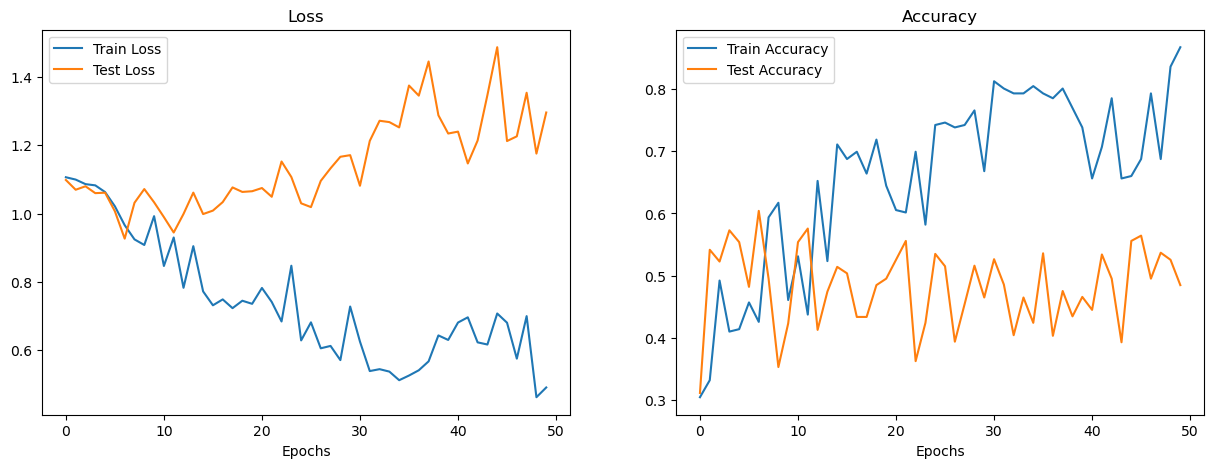

In [147]:
plot_loss_curves(model_0_result)

# Model 1: TinyVGG with data augmentation
## Create transfoem with data augmentation

In [148]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

## Create train & test `dataset` and `dataloader` with data augmentation

In [149]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

train_data = ImageFolder(
    root=train_dir,
    transform=train_transform
)

test_data = ImageFolder(
    root=test_dir,
    transform=test_transform
)

In [150]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
)

## Construct and train model 1

In [151]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(test_data.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

## Train the model

In [152]:
torch.manual_seed(42)

NUM_EPOCHS = 50

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [153]:
from timeit import default_timer as timer

start = timer()

model_1_result = train(
    model=model_1,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device
)


end = timer()

print(f"Total training time: {end - start:.4f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train acc: 0.2500, Train Loss: 1.1036 | Test acc: 0.2604, Test Loss: 1.1007
Epoch: 1 | Train acc: 0.4258, Train Loss: 1.0725 | Test acc: 0.2604, Test Loss: 1.1419
Epoch: 2 | Train acc: 0.3047, Train Loss: 1.1432 | Test acc: 0.2604, Test Loss: 1.1623
Epoch: 3 | Train acc: 0.4258, Train Loss: 1.0862 | Test acc: 0.2604, Test Loss: 1.1016
Epoch: 4 | Train acc: 0.3047, Train Loss: 1.0962 | Test acc: 0.2604, Test Loss: 1.0863
Epoch: 5 | Train acc: 0.2891, Train Loss: 1.0846 | Test acc: 0.3305, Test Loss: 1.0643
Epoch: 6 | Train acc: 0.4453, Train Loss: 1.0681 | Test acc: 0.2708, Test Loss: 1.0664
Epoch: 7 | Train acc: 0.4727, Train Loss: 1.0385 | Test acc: 0.2917, Test Loss: 1.0808
Epoch: 8 | Train acc: 0.5078, Train Loss: 1.0294 | Test acc: 0.3125, Test Loss: 1.1060
Epoch: 9 | Train acc: 0.5273, Train Loss: 0.9848 | Test acc: 0.3021, Test Loss: 1.0992
Epoch: 10 | Train acc: 0.3984, Train Loss: 1.0710 | Test acc: 0.3741, Test Loss: 1.1007
Epoch: 11 | Train acc: 0.4180, Train Loss:

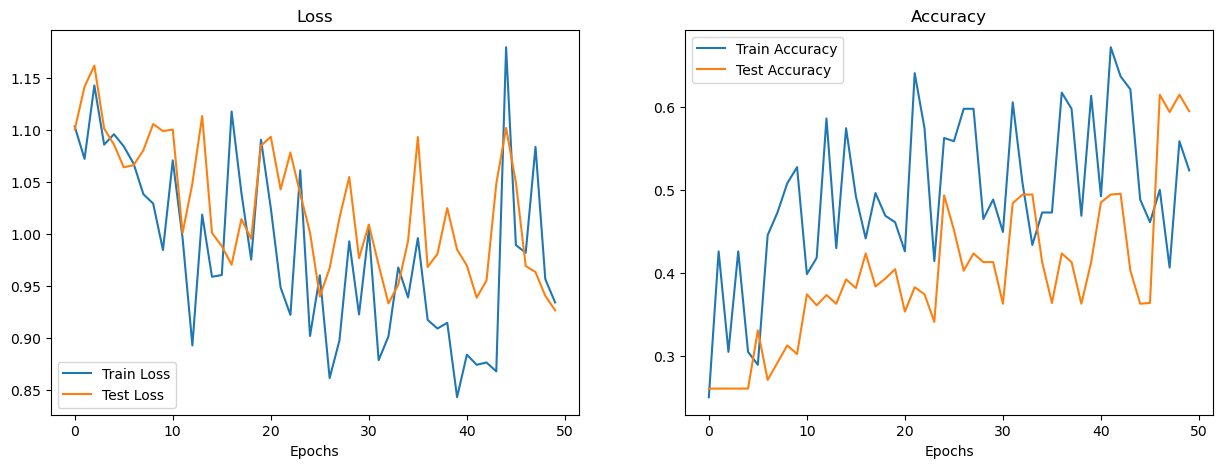

In [154]:
plot_loss_curves(model_1_result)

# Compare model results
* After evaluating our models, It's important to compare them to each other.
    1. Hard Coding
    2. using `torch.utils.tensorboard`
    3. using [weights & biases](https://wandb.ai/site)
    4. [MLFlow](https://mlflow.org/)

In [160]:
# WE will use the Hard code
import pandas as pd

model_0_df = pd.DataFrame(model_0_result)
model_1_df = pd.DataFrame(model_1_result)

In [161]:
model_0_df.sample(5)

,train_acc,train_loss,test_acc,test_loss
36,0.785156,0.541807,0.403409,1.345035
13,0.523438,0.904801,0.474432,1.061369
27,0.742188,0.612991,0.454545,1.132541
6,0.425781,0.966130,0.604167,0.926771
24,0.742188,0.629131,0.535038,1.030054


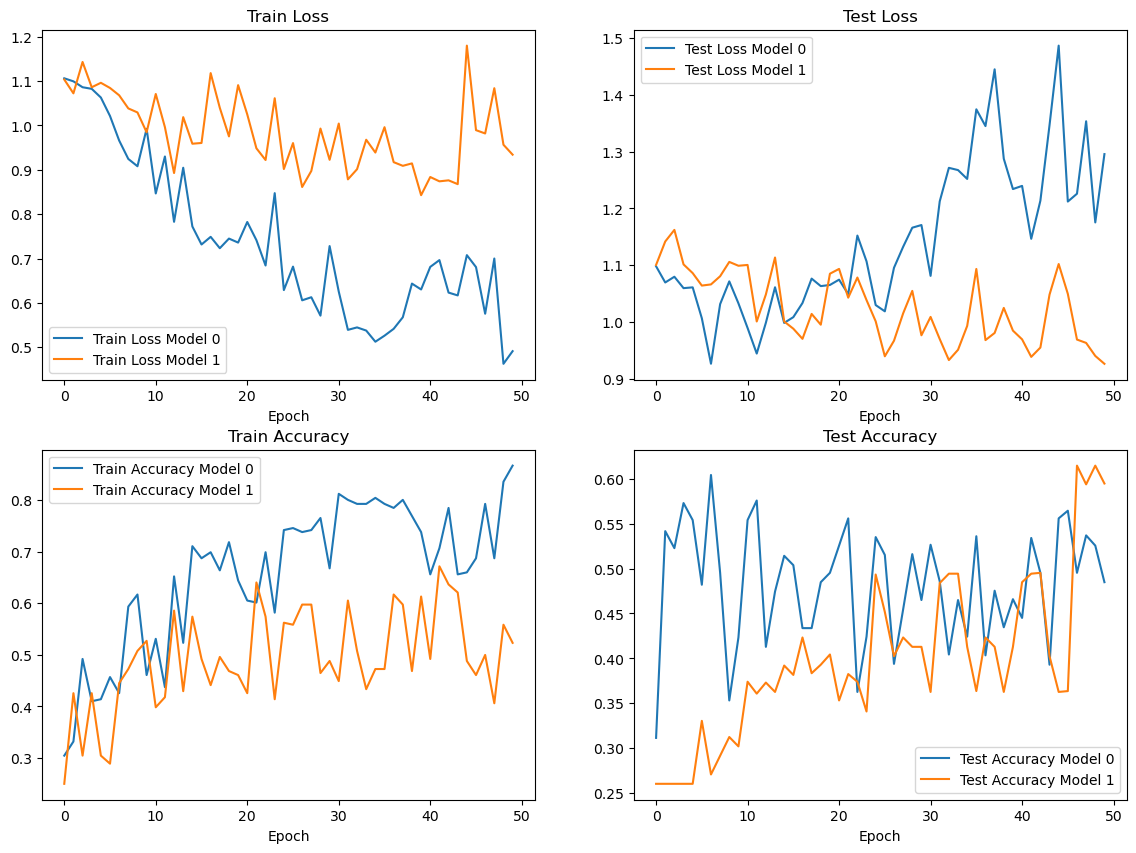

In [176]:
plt.figure(figsize=(14, 10))

epochs = range(len(model_0_df))

# plot train Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df.train_loss, label="Train Loss Model 0")
plt.plot(epochs, model_1_df.train_loss, label="Train Loss Model 1")
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.legend()

# plot test Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df.test_loss, label="Test Loss Model 0")
plt.plot(epochs, model_1_df.test_loss, label="Test Loss Model 1")
plt.title("Test Loss")
plt.xlabel("Epoch")
plt.legend()

# plot train Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df.train_acc, label="Train Accuracy Model 0")
plt.plot(epochs, model_1_df.train_acc, label="Train Accuracy Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epoch")
plt.legend()

# plot test Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df.test_acc, label="Test Accuracy Model 0")
plt.plot(epochs, model_1_df.test_acc, label="Test Accuracy Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.legend()

# Making a prediction on a custom image

In [180]:
import requests


custom_image_path = data_path / "pizza-dad.jpeg"
target_img = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    
    with open(custom_image_path, "wb") as writer:
        response = requests.get(target_img)
        print(f"Downloading {custom_image_path} ...")
        writer.write(response.content)
        
else:
    print(f"{custom_image_path} already exists, skipping download..")

In [203]:
# First way to read an image
img = Image.open("data/pizza-dad.jpeg")
tensor_img = test_transform(img) # Turn it to tensor and resize it
tensor_img = tensor_img.unsqueeze(0)
tensor_img.shape

torch.Size([1, 3, 64, 64])

In [278]:
def get_output_predict(model: torch.nn.Module, img: torch.FloatTensor):
    model.eval()
    with torch.inference_mode():
        output = model(img)
        
        label = torch.argmax(torch.softmax(output, dim=-1), dim=-1)
        class_name = class_names[label]
        
    return f"I think the image is a {class_name}"

In [279]:
get_output_predict(model_0, tensor_img)

'I think the image is a pizza'

In [280]:
get_output_predict(model_1, tensor_img)

'I think the image is a pizza'

_____

In [264]:
# Second way to read an image
from torchvision.io import read_image
# Change the type from unit to float, then make a scale to the image.
custom_image = read_image(str(custom_image_path)).type(torch.float32) / 255.0
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [265]:
custom_image.shape

torch.Size([3, 4032, 3024])

In [270]:
# Create transform pipeline to resize the image
from torchvision import transforms
custom_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

In [275]:
transformed_custom_image = custom_transform(custom_image)
transformed_custom_image.shape

torch.Size([3, 64, 64])

In [276]:
# Add another dimension that represent the batch size
transformed_custom_image = transformed_custom_image.unsqueeze(0)
transformed_custom_image.shape

torch.Size([1, 3, 64, 64])

In [281]:
get_output_predict(model_0, transformed_custom_image)

'I think the image is a pizza'

* To make a prediction on Custom image we had to:
    1. Load the image and turn it into `Tensor`
    2. The Image has same datatype as the model
    3. The image has same hape as the data which the model has trained on. don't forget the `batch_size`.
    4. The image has the same device as the model

# Putting it all together

In [292]:
from torchvision.io import read_image

def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str],
    transform=None,
    device: torch.device = device
):
    
    # Read the image
    img = read_image(str(image_path)).type(torch.float32) / 255.0
    
    # apply the transformation
    if transform:
        img = transform(img)
    
    # add a dimension for the batch size
    img = img.unsqueeze(dim=0)
    
    # set the model on eval mode
    model.eval()
    img = img.to(device)
    
    with torch.inference_mode():
        output = model(img) # raw -> logits
        
    label = torch.argmax(torch.softmax(output, dim=-1), dim=-1) # logits -> predictions -> label
    class_name = class_names[label]
        
    plt.imshow(img.squeeze(dim=0).permute(1, 2, 0))
    plt.title(f"Pred: {class_name}")
    plt.axis("off")

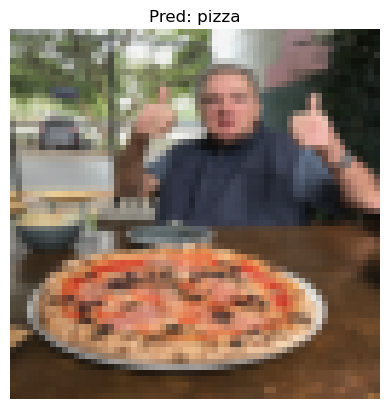

In [293]:
pred_and_plot_image(model_1, custom_image_path, class_names, custom_transform, device)